# Server-side Feature Inference Attacks against Split Learning: `credit-card`

## Import packages and dataset

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sl_with_attack
from sl_with_attack import *
from datasets import *

xpriv, xpub, max_values, min_values = load_credit_card()

## Setting up hyperparameters and util functions

In [2]:
batch_size = 64
id_setup = 4
hparams = {
    'WGAN' : True,
    # 'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
    'lr_classify': 0.001,
}

iterations = 5000
log_frequency = 200

def plot_log(ax, x, y, label=None, color='blue'):
    ax.plot(x, y, color=color)
    ax.grid()
    if label is not None:
        ax.set(title=label)

## Model architectures

In [4]:
def f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.BatchNormalization()(xin)
    x = tf.keras.layers.Dense(32, activation="relu")(xin)
    output = tf.keras.layers.Dense(64, activation="relu")(x)
    return tf.keras.Model(xin, output)

def g(input_shape, class_num):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(128, activation="relu")(xin)
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(xin, output)

def encoder(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = None
    x = tf.keras.layers.Dense(32, activation=act)(xin)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    return tf.keras.Model(xin, x)

# def f_inverse(input_shape, channels=

def decoder(input_shape, channels=3):
    xin = tf.keras.layers.Input(input_shape)
    act = None
    x = tf.keras.layers.Dense(64, activation=act)(xin)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(23)(x)
    # x = tf.abs(x)
    # x = x * (max_values - min_values) + min_values
    return tf.keras.Model(xin, x)

def discriminator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(256)(xin)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, x)

In [5]:
models = (f, g, f, decoder, discriminator)

## Passive Attack

In [6]:
passive = sl_with_attack(models, xpriv, xpub, id_setup-1, batch_size, hparams, 2, server_attack="passive")
log_passive = passive(iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
[log--03%-0000199] reconstruction validation: 4111602688.0000
Original task: train loss: 457.0266 train accuracy: 0.6855
[log--07%-0000399] reconstruction validation: 3695970560.0000
Original task: train loss: 215.2826 train accuracy: 0.6880
[log--11%-0000599] reconstruction validation: 3378948608.0000
Original task: train loss: 183.2734 train accuracy: 0.6840
[log--15%-0000799] reconstruction validation: 3051020032.0000
Original task: train loss: 104.2942 train accuracy: 0.6886
[log--19%-0000999] reconstruction validation: 2732536832.0000
Original task: train loss: 83.3061 train accuracy: 0.6947
[log--23%-0001199] reconstruction validation: 2464091648.0000
Original task: train loss: 76.8032 train accuracy: 0.6898
[log--27%-0001399] reconstruction validation: 2340752640.0000
Original task: train loss: 64.7357 train accuracy: 0.6819
[log--31%-0001599] reconstruction validation: 2367618048.0000
Original task: train loss: 49.6219 train accuracy: 0.6948
[log--35%-0001799] recons

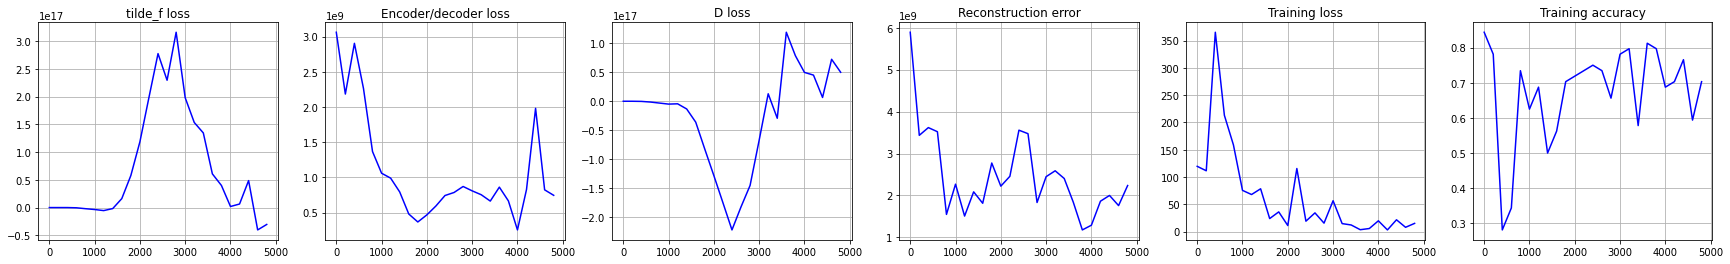

In [7]:
n = 6
fix, ax = plt.subplots(1, n, figsize=(n*5, 4))
x = np.arange(0, len(log_passive)) * log_frequency

plot_log(ax[0], x, log_passive[:, 0],  label='tilde_f loss')
plot_log(ax[1], x, log_passive[:, 1],  label='Encoder/decoder loss')
plot_log(ax[2], x, log_passive[:, 2],  label='D loss')
plot_log(ax[3], x, log_passive[:, 3],  label='Reconstruction error')
plot_log(ax[4], x, log_passive[:, 4], label='Training loss')
# plot_log(ax[4], x, log_no_attack[:,0], color='red')
plot_log(ax[5], x, log_passive[:, 5],  label='Training accuracy')
# plot_log(ax[5], x, log_no_attack[:,1], color='red')

In [8]:
X = np.concatenate([x[0].numpy()[None] for x in xpriv.take(5)])
original = X.astype('int')
constructed = passive.attack(X)[0].astype('int')
for i in range(5):
    print("compare:")
    print(original[i])
    print(constructed[i])

compare:
[130000      1      3      1     44      0      0      0      0      0
      0 123770 122189 118909  84865  86846  88069   4600   4871   3500
   3500   3500   3100]
[18134  -645   893  -294 -1393  2360   834   879   316 -1942   674  -699
   973  2660   507  1620 -2534   317  1706  1144   913 -1240 -1233]
compare:
[140000      2      2      1     42      0      0      0      0      0
      0 111496 112133  69529  70804  70781  66735   6022   3021   5012
   5112   3000   5000]
[11891  -522   225  -361  -754  1076     8   498    63 -1244  1171  -304
   924   669   161  1058 -1456  -584   949  1483   424   -76 -1299]
compare:
[150000      2      2      2     27      0      0      0      0      0
      0  23165  24515  25592  24949  26846  26908   1723   1800   1100
   2300   1000   1300]
[52070 -2344  1378  -250 -1017  4027  1591   948  -933 -5846  3349  2330
  7086  7897  4891  6725 -1887 -2748  3693  5243  1658 -2314 -1455]
compare:
[170000      2      1      2     26      0    

## Save the models and outputs

In [29]:
no_attack.f.save('models/no_attack/f')
no_attack.g.save('models/no_attack/g')
active.f.save('models/active/f')
active.g.save('models/active/g')
active.decoder.save('models/active/decoder')
passive.f.save('models/passive/f')
passive.g.save('models/passive/g')
passive.decoder.save('models/passive/decoder')

INFO:tensorflow:Assets written to: models/no_attack/f\assets
INFO:tensorflow:Assets written to: models/no_attack/g\assets
INFO:tensorflow:Assets written to: models/active/f\assets
INFO:tensorflow:Assets written to: models/active/g\assets
INFO:tensorflow:Assets written to: models/active/decoder\assets
INFO:tensorflow:Assets written to: models/passive/f\assets
INFO:tensorflow:Assets written to: models/passive/g\assets
INFO:tensorflow:Assets written to: models/passive/decoder\assets


In [20]:
np.savetxt('./log/log_no_attack.csv', log_no_attack, delimiter=',')
np.savetxt('./log/log_active.csv', log_active, delimiter=',')
np.savetxt('./log/log_passive.csv', log_passive, delimiter=',')

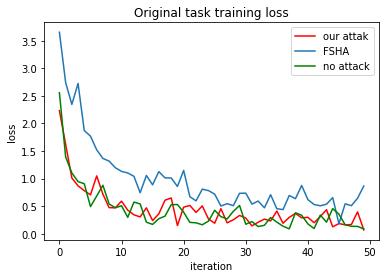

In [67]:
# plot the training loss:
plt.title("Original task training loss")
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(log_passive[:,4], color='red')
plt.plot(log_active[:,4])
plt.plot(log_no_attack[:,0], color='green')
plt.legend(['our attak', 'FSHA', 'no attack'], loc='upper right')
plt.show()

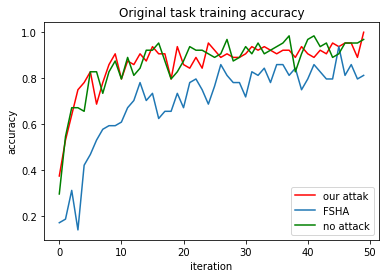

In [68]:
# plot the training accuracy:
plt.title("Original task training accuracy")
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.plot(log_passive[:,5], color='red')
plt.plot(log_active[:,5])
plt.plot(log_no_attack[:,1], color='green')
plt.legend(['our attak', 'FSHA', 'no attack'], loc='lower right')
plt.show()

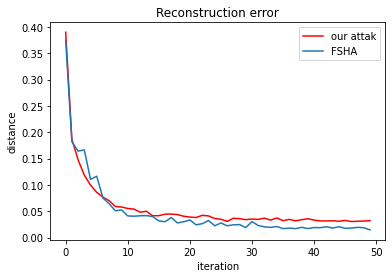

In [66]:
# plot the reconstruction error:
plt.title("Reconstruction error")
plt.ylabel('distance')
plt.xlabel('iteration')
plt.plot(log_passive[:,3], color='red')
plt.plot(log_active[:,3])
plt.legend(['our attak', 'FSHA'], loc='upper right')
plt.show()